# **HCL TECH**
Forecasting stock price with ARIMA model:

**Loading the data:**

In [7]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/content/HCLTECH.NS.csv'
stock_data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Check the loaded data
print(stock_data.head())


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-07-26  1110.199951  1120.849976  1110.099976  1115.000000  1073.240479   
2023-07-27  1115.000000  1122.699951  1108.949951  1117.349976  1075.502563   
2023-07-28  1114.050049  1118.500000  1097.449951  1103.550049  1062.219238   
2023-07-31  1108.000000  1119.500000  1096.000000  1116.699951  1074.876831   
2023-08-01  1120.000000  1142.000000  1111.900024  1138.500000  1095.860352   

             Volume  
Date                 
2023-07-26  1969964  
2023-07-27  1769815  
2023-07-28  2031899  
2023-07-31  2526624  
2023-08-01  2710536  


**Checking for Missing Values**

In [8]:
# Check for missing values
print(stock_data.isnull().sum())


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


**Visualize the Data**

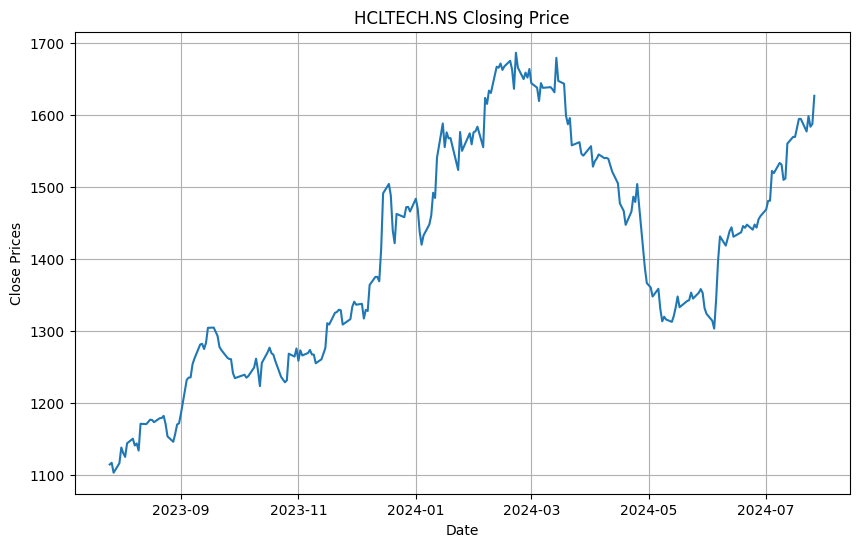

In [9]:
# Visualize the stock’s daily closing price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('HCLTECH.NS Closing Price')
plt.show()


**Checking Whether the Data is Stationary**

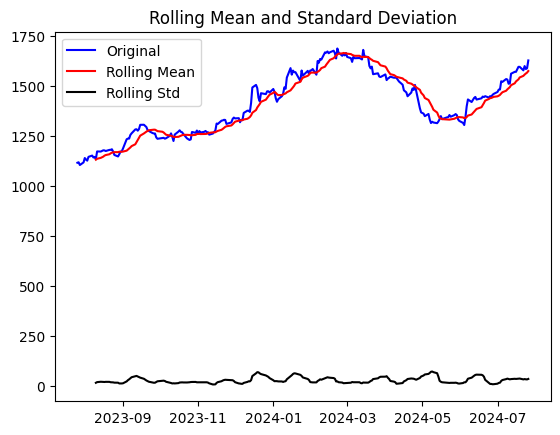

Test Statistics                 -1.355509
p-value                          0.603410
No. of lags used                 0.000000
Number of observations used    244.000000
critical value (1%)             -3.457438
critical value (5%)             -2.873459
critical value (10%)            -2.573122
dtype: float64


In [10]:
# ADF Test for Stationarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' % key] = values
    print(output)

# Test for stationarity
df_close = stock_data['Close']
test_stationarity(df_close)


**Converting Non-Stationary to Stationary Data**

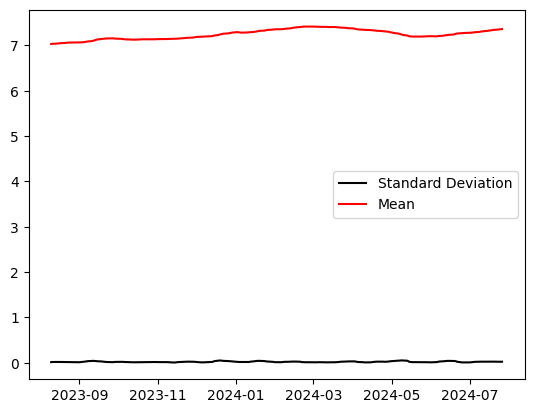

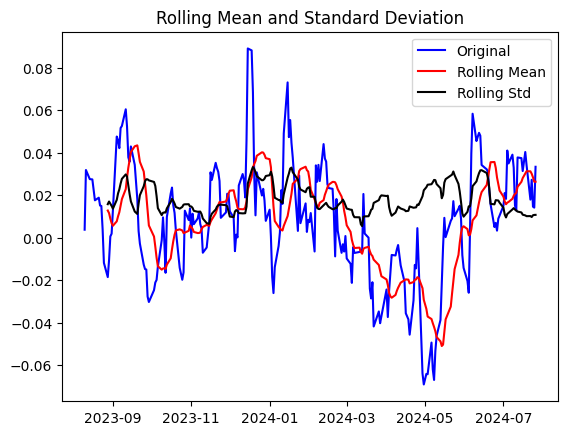

Test Statistics                 -3.749709
p-value                          0.003466
No. of lags used                 0.000000
Number of observations used    233.000000
critical value (1%)             -3.458731
critical value (5%)             -2.874026
critical value (10%)            -2.573424
dtype: float64


In [11]:
# Log transform and remove trend
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(std_dev, color="black", label="Standard Deviation")
plt.plot(moving_avg, color="red", label="Mean")
plt.legend()
plt.show()

# Remove moving average to get stationary data
df_log_moving_avg_diff = df_log - moving_avg
df_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(df_log_moving_avg_diff)


**Train-Test Split**

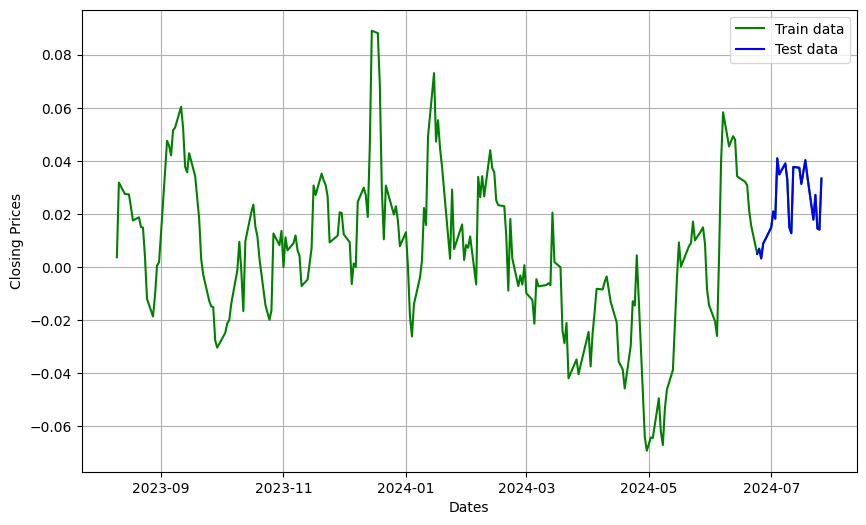

In [12]:
# Split data into train and test sets
train_data, test_data = df_log_moving_avg_diff[:int(len(df_log_moving_avg_diff)*0.9)], df_log_moving_avg_diff[int(len(df_log_moving_avg_diff)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log_moving_avg_diff, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()


**Apply auto_arima Function**

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-888.673, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1213.067, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1050.078, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1213.576, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1213.485, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1212.666, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1213.049, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1212.337, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1212.407, Time=0.29 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 2.067 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 609.788
Date:                Fri, 26 Jul 2024   A

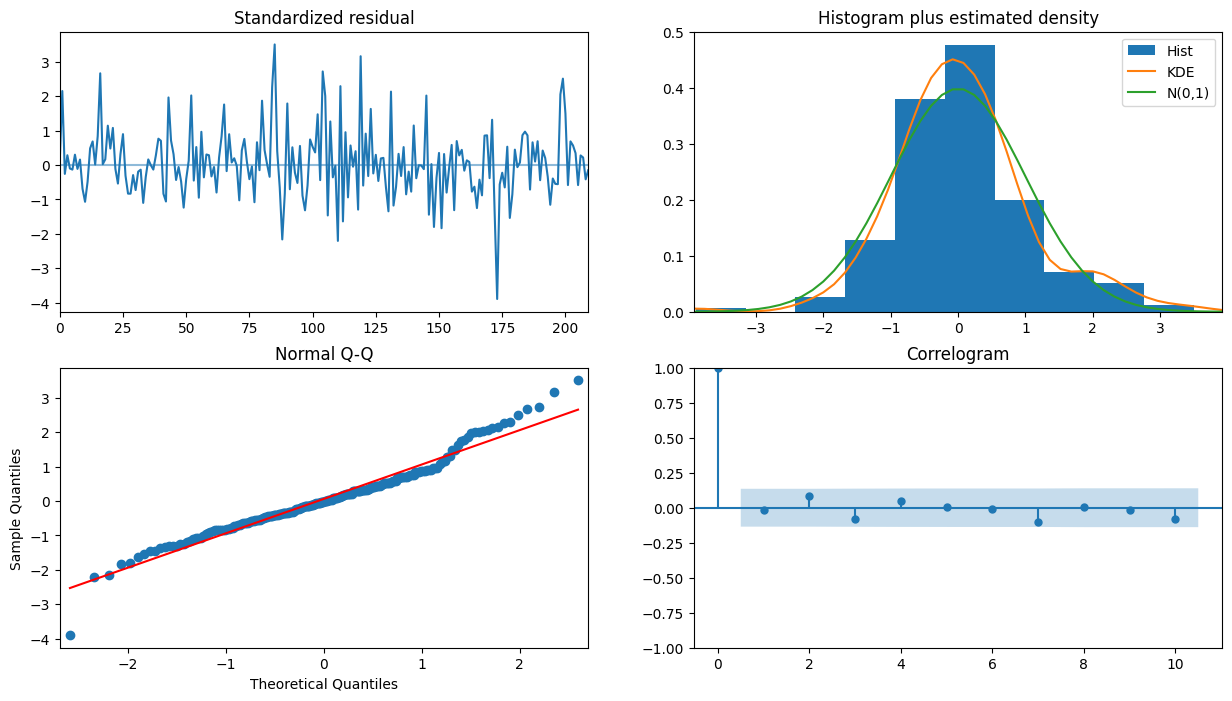

In [13]:
# Build Auto ARIMA model
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, test='adf', max_p=3, max_q=3, m=1, d=None, seasonal=False, start_P=0, D=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


**ARIMA Model**

In [14]:
# Fit the ARIMA model
model = ARIMA(train_data, order=model_autoARIMA.order)
fitted = model.fit()
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  210
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 610.201
Date:                Fri, 26 Jul 2024   AIC                          -1212.402
Time:                        07:43:39   BIC                          -1199.014
Sample:                             0   HQIC                         -1206.990
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.007      0.852      0.394      -0.008       0.020
ar.L1          0.9824      0.059     16.767      0.000       0.868       1.097
ar.L2         -0.1111      0.057     -1.946      0.0

**Model Predictions**

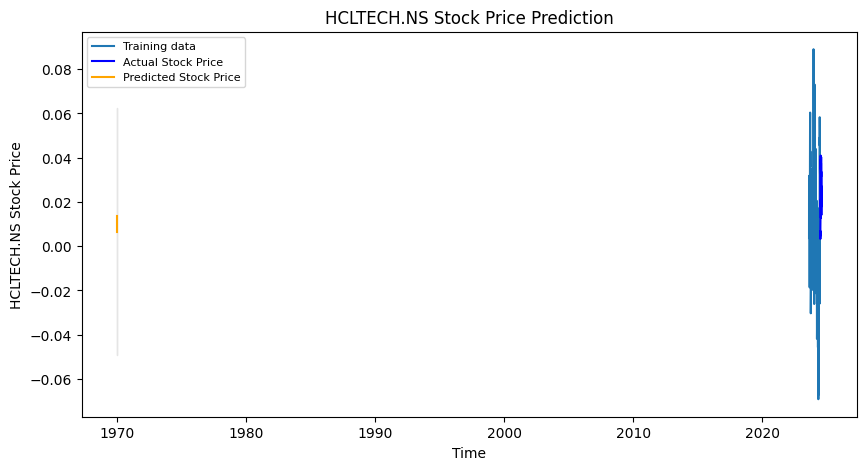

In [15]:
# Forecast
forecast = fitted.get_forecast(steps=len(test_data))
fc_series = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Convert indices to datetime
fc_series.index = pd.to_datetime(fc_series.index)
conf.index = pd.to_datetime(conf.index)

# Plot the forecast for the range from 2020 to 2023
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=.10)
plt.title('HCLTECH.NS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('HCLTECH.NS Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


**Performance of the Model**

In [16]:
# Report performance
mse = mean_squared_error(test_data, fc_series)
mae = mean_absolute_error(test_data, fc_series)
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
mape = np.mean(np.abs(fc_series - test_data) / np.abs(test_data))
print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)


MSE: 0.00040528247151633295
MAE: 0.016798244796368142
RMSE: 0.020131628635466456
MAPE: nan
